# **Sentiment Analysis**

## **Imports**

In [64]:
#python -m spacy download de_core_news_sm
import spacy
import pandas as pd
import numpy as np

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import itertools

from IPython.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, similarities
from gensim.matutils import sparse2full
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import display
from PyPDF2 import PdfReader
from transformers import LongformerTokenizer, LongformerModel
from sklearn.metrics.pairwise import cosine_similarity

## **Extract Manifestos**

In [4]:
sp = spacy.load("de_core_news_sm")

def extract_text_from_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    num_pages = len(reader.pages)
    full_text = ''

    for page_num in range(num_pages):
        page = reader.pages[page_num]
        text = page.extract_text()
        full_text += text

    return full_text

cdu_text = extract_text_from_pdf('../manifestos/cdu_csu.pdf')
with open('../manifestos/cdu_csu_text.txt', 'w', encoding='utf-8') as file:
    file.write(cdu_text)

spd_text = extract_text_from_pdf('../manifestos/spd.pdf')
with open('../manifestos/spd_text.txt', 'w', encoding='utf-8') as file:
    file.write(spd_text)

gruene_text = extract_text_from_pdf('../manifestos/gruene.pdf')
with open('../manifestos/gruene_text.txt', 'w', encoding='utf-8') as file:
    file.write(gruene_text)

afd_text = extract_text_from_pdf('../manifestos/afd.pdf')
with open('../manifestos/afd_text.txt', 'w', encoding='utf-8') as file:
    file.write(afd_text)

linke_text = extract_text_from_pdf('../manifestos/linke.pdf')
with open('../manifestos/linke_text.txt', 'w', encoding='utf-8') as file:
    file.write(linke_text)
    
fdp_text = extract_text_from_pdf('../manifestos/fdp.pdf')
with open('../manifestos/fdp_text.txt', 'w', encoding='utf-8') as file:
    file.write(fdp_text)

party_docs = []
party_docs.append(cdu_text)
party_docs.append(spd_text)
party_docs.append(gruene_text)
party_docs.append(afd_text)
party_docs.append(linke_text)
party_docs.append(fdp_text)

## **Preprocessing**

In [5]:
class TextPreprocessor:
    def __init__(self):
        self.nlp = spacy.load("de_core_news_sm")
    
    def tokenize_documents(self, documents):
        tokenized_docs = []
        for doc in documents:
            doc_tokens = self.nlp(doc)
            tokenized_tokens = [token.text for token in doc_tokens]
            tokenized_docs.append(tokenized_tokens)
        return tokenized_docs
    
    def remove_tags(self, tokenized_docs):
        without_tag_docs = []
        
        for doc_tokens in tokenized_docs:
            cleaned_tokens = [token.strip().replace('\n', '') for token in doc_tokens if token.strip().replace('\n', '') not in ['\n', '']]
            without_tag_docs.append(cleaned_tokens)
        return without_tag_docs
    
    def lemmatize_documents(self, tokenized_docs):
        lemmatized_docs = []
        for doc_tokens in tokenized_docs:
            lemmatized_tokens = [token.lemma_ for token in self.nlp(' '.join(doc_tokens))]
            lemmatized_docs.append(lemmatized_tokens)
        return lemmatized_docs
    
    def remove_stopwords_punctuations_numbers(self, lemmatized_docs):
        clean_docs = []
        for lemmatized_tokens in lemmatized_docs:
            lemmatized_tokens_no_stopwords = [token for token in lemmatized_tokens if not self.nlp.vocab[token].is_stop]
            lemmatized_tokens_no_punct = [token for token in lemmatized_tokens_no_stopwords if not self.nlp.vocab[token].is_punct]
            lemmatized_tokens_no_nums = [token for token in lemmatized_tokens_no_punct if not self.nlp.vocab[token].like_num]
            clean_docs.append(lemmatized_tokens_no_nums)
        return clean_docs

preprocessor = TextPreprocessor()

# Tokenization
tokenized = preprocessor.tokenize_documents(party_docs)

# Clear Tags
tag_cleared = preprocessor.remove_tags(tokenized)

# Lemmatization
lemmatized = preprocessor.lemmatize_documents(tag_cleared)

# Removing Stopwords, Punctuation, and Numbers
cleaned = preprocessor.remove_stopwords_punctuations_numbers(lemmatized)

## **Sentiment**

### German Sentiment Model

https://huggingface.co/oliverguhr/german-sentiment-bert?text=Da+sisrt+super

In [50]:
from germansentiment import SentimentModel

nlp = spacy.load("de_core_news_sm")
with open('../manifestos/cdu_csu_text.txt', 'r', encoding='utf-8') as file:
    manifesto_text = file.read()

doc = nlp(manifesto_text)
paragraphs = [p.text.strip() for p in doc.sents if len(p.text.strip()) > 1] 

data = {'Paragraph': [], 'Sentiment': [], 'Score': []}

model = SentimentModel()

for paragraph in paragraphs:
    pred_class, probabilities = model.predict_sentiment([paragraph], output_probabilities=True)
    max_probability = max(probabilities[0], key=lambda x: x[1])[1]
    
    data['Paragraph'].append(paragraph)
    data['Sentiment'].append(pred_class[0])
    data['Score'].append(max_probability)

# Erstellung eines DataFrame
df = pd.DataFrame(data)

# Ausgabe des DataFrame
print(df)

# Speichern des DataFrames in einer CSV-Datei
df.to_csv('sentiment_results.csv', index=False)

                                              Paragraph Sentiment     Score
0     Das Programm für Stabilität   \n   und Erneuer...   neutral  0.999025
1                                         GEMEINSAM FÜR   neutral  0.479474
2                                          EIN MODERNES  positive  0.993092
3                                          DEUTSCHLAND.  positive  0.872862
4     Seite 1 von 139 Inhaltsverzeichnis \n \nEinlei...   neutral  0.999956
...                                                 ...       ...       ...
3866                                          4994  \n•  positive  0.903174
3867  Wir unterstützen die Bewerbungen für internati...   neutral  0.999980
3868  Diese müssen ökologisch, ökonomisch und sozial...   neutral  0.999991
3869  Das ist auch der M aßstab für eine 4997  \nBew...   neutral  0.999945
3870                                               4998  positive  0.904764

[3871 rows x 3 columns]


In [58]:
df[df.Sentiment == "positive"]

,Paragraph,Sentiment,Score
2,EIN MODERNES,positive,0.993092
3,DEUTSCHLAND.,positive,0.872862
5,.................................................,positive,0.937838
10,.................................................,positive,0.956889
12,Neue Aufmerksamkeit für den asiatisch-pazifisc...,positive,0.985758
...,...,...,...
3858,4985 \n•,positive,0.909667
3860,4987 \n•,positive,0.907502
3863,4991 \n•,positive,0.911100
3866,4994 \n•,positive,0.903174


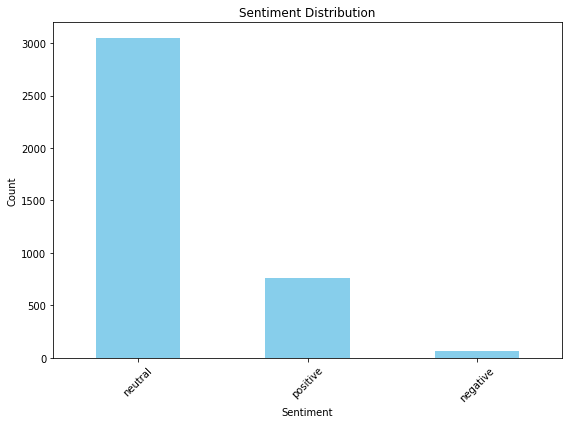

In [59]:
import matplotlib.pyplot as plt

sentiment_counts = df['Sentiment'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [65]:
for index, row in df.iterrows():
    sentiment = row['Sentiment']
    paragraph = row['Paragraph']

    # Set text color based on sentiment
    if sentiment == 'positive':
        color = 'green'
    elif sentiment == 'negative':
        color = 'red'
    else:
        color = 'black'

    # Display sentence with color-coded sentiment using HTML
    display(HTML(f'<font color="{color}">{paragraph}</font>'))
